In [2]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [3]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03  # regularizer for Closed Form Solution: tunable hyperparameter
TrainingPercent = 80  # 80% of sample input will be assigned as training data set
ValidationPercent = 10 # 10% for validation
TestPercent = 10  # 10% for Testing the model
M = 15 # no of clusters # radial basis functions  # also represents the complexity of the model
PHI = []  # store basis functions in this list
IsSynthetic = False   


In [4]:
# get ground truth, target vector 't', which is the first column of the dataset. 
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

# Getting raw data #x matrix 
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1) # remove columns with all elements as 0's. 
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix

# 80% o/p target vector assigned as training 
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

#80 of the data matrix assigned as training
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#10% of dataset assigned a validation
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#10% of target vector for validation
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

# get variance of the training data and generate a diagonal matrix of variances also called big sigma. 
#generate a 41x41 diagonal matrix with all other elements as zero.
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))  # creating a dummy zero squares matrix m X m
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01)) # length of the training data 80% of DataT 
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))  # np.var : compute variance 
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]  # diagonal elements of bigsigma : variance 
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        # not necessary
        BigSigma = np.dot(200,BigSigma)   # scaling the variance by multiplying it by 200
    ##print ("BigSigma Generated..")
    return BigSigma


#computing the exponential term of the Gaussian basis function matrices and return a scalar value
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

#computing Gaussian Radial basis function.
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

#generating design matrix
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    #generate a matrix placeholder 
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    
    # iterate : for each mu(anchor point), iterate over the row data points
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)): # 
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI


#closed form solution # w/ regularizer  : Returns w*
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0])) # identity matrix
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)  
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W


# #contruct new design matrix based on validation and testing data
# def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
#     DataT = np.transpose(Data)
#     TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
#     PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
#     BigSigInv = np.linalg.inv(BigSigma)
#     for  C in range(0,len(MuMatrix)):
#         for R in range(0,int(TrainingLen)):
#             PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
#     #print ("PHI Generated..")
#     return PHI

#validation 
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

# computing Erms
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    saccuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [5]:
#get targer and rawdata 
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)


a = np.transpose(RawData)
print(a.shape)


/Users/TenzinNorden/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.
/Users/TenzinNorden/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 'U' mode is deprecated
  


(69623, 41)


## Prepare Training Data

In [6]:
#generate training target and training data
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
print(len(RawData[0]))

(55699,)
(41, 55699)
69623


## Prepare Validation Data

In [7]:
# Generate validation target and data.
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [8]:
#generate test target and data
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

# plt.hist(TestData, bins = 'auto')
# plt.show()

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [ ]:
M = [1, 5, 10, 15, 20, 25, 30, 35, 40, 60, 80, 100]

Erms_Tr = []
Erms_Val = []
Erms_Test = []

for m in M:
    ErmsArr = []
    AccuracyArr = []

# k means clustering using scikit learn, # fit in the data after clustering
    kmeans = KMeans(n_clusters=m, random_state=0).fit(np.transpose(TrainingData))
#centroid of clusters
    Mu = kmeans.cluster_centers_

# based on centroid, calculate variance 
    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)

#GetPhiMatrix: to get radial basis function# 1.3 design matrix
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

    #print(TRAINING_PHI[0])
    
    
    
    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)

    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
    TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
    
    Erms_Tr.append(TrainingAccuracy.split(',')[1])
    Erms_Val.append(ValidationAccuracy.split(',')[1])
    Erms_Test.append(TestAccuracy.split(',')[1])
    0.01
    #TrainingAccuracy.split(',')[1]
    
print(len(Erms_Tr))

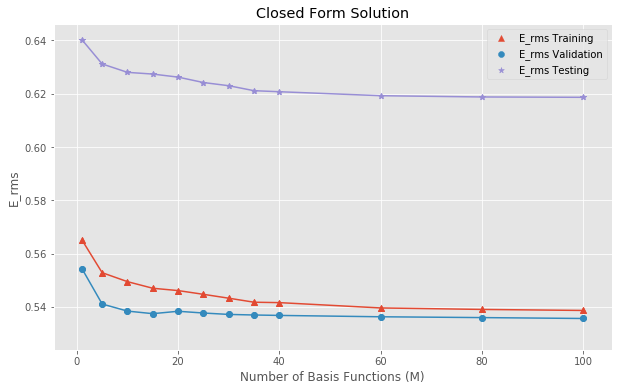

In [10]:
#plotting Erms vs M for training, validation and testing. # results from closed form solution

plt.figure(figsize=(10,6))
plt.scatter(M, Erms_Tr, marker = '^', label = 'E_rms Training')
plt.plot(M, Erms_Tr, marker = '^')
plt.scatter(M, Erms_Val, marker = 'o', label = 'E_rms Validation')
plt.plot(M, Erms_Val, marker = 'o')
plt.scatter(M, Erms_Test, marker = '*', label = 'E_rms Testing')
plt.plot(M, Erms_Test, marker = '*')
plt.title('Closed Form Solution')

plt.legend()
plt.xlabel('Number of Basis Functions (M)')
plt.ylabel('E_rms')
plt.grid(True)
plt.show()


In [11]:
#print out the shapes of all the matrix generated
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(100, 41)
(41, 41)
(55699, 100)
(100,)
(6962, 100)
(6961, 100)


## Finding Erms on training, validation and test set 

In [12]:
#compute  validation test
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

# computing Erms for training, validation and test set.
TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

#TrainingAccuracy

In [13]:
print ('UBITname = tenzinno')
print ('Person Number = 50096989')
print ('----------------------------------------------')
print ("-----------------Letor Data-------------------")
print ('------------------------------------')
print ("----Closed Form with Radial Basis Function----")
print ('----------------------------------------------')
print ("M = \nLambda = ")
print ("E_rms Training  = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation  = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing  = " + str(float(TestAccuracy.split(',')[1])))

UBITname = tenzinno
Person Number = 50096989
----------------------------------------------
-----------------Letor Data-------------------
------------------------------------
----Closed Form with Radial Basis Function----
----------------------------------------------
M = 
Lambda = 
E_rms Training  = 0.5386691233391624
E_rms Validation  = 0.5356554245986496
E_rms Testing  = 0.6186146522549639


## Gradient Descent solution for Linear Regression

In [14]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 30 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 9 mins!----------------
----------------------------------------------------


In [15]:
W_Now        = np.dot(220, W) # unnecessary
La           = 5   #lambda: 0.01 , .05, .1, .5, 1, 5, 10
#learningRate = 0.01  # experimnet with 0.01 to 0.5
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
#m = 15
E_Tr   = []

# no. of iteration->hyperparameter# 
#iteration over 1000 data points. adjustable: can stop when Erms value is stagnant
#400 iterations is used when changing different M

for i in range(0, 1000):  
    learningRate = 0.1/np.sqrt(5*(i+1)) # learning rate decreases with every iteration, # self adjusting 
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)  # 
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    # eqn 10
    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W  # new weight
    W_Now         = W_T_Next # updated weight
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT, TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
  
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))


In [16]:
#prints the results of Erms
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.5403
E_rms Validation = 0.53599
E_rms Testing    = 0.61553


/Users/TenzinNorden/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


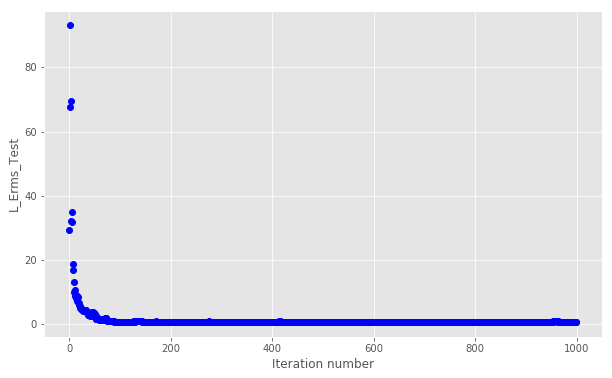

In [17]:
#plotting Erms_Test vs iteration
iterations = 1000

plt.figure(figsize=(10,6))
plt.plot(range(len(L_Erms_Test)),L_Erms_Test,'bo', label= '')
plt.grid(True)

plt.xlabel("Iteration number")
plt.ylabel("L_Erms_Test")
plt.xlim([-0.05*iterations,1.05*iterations])

plt.legend()
plt.savefig('Erms_Test_iteration.png')
plt.show()


